In [91]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [92]:
data_mts = pd.read_excel('comp.xlsx', sheet_name='MTS')
data_surgut = pd.read_excel('comp.xlsx', sheet_name='SURGUT')

In [93]:
data_mts

,date,long_L,short_L,L,mcap,r
0,2024,624.608234,614.699351,927.003468,420.958747,0.068743
1,2023,571.532865,417.030811,702.797244,496.497511,0.068743
2,2022,575.511029,312.334161,600.089675,472.417032,0.068743
3,2021,568.219641,271.190348,555.300168,597.315782,0.068743
4,2020,600.868726,143.075486,443.509849,661.863456,0.068743
5,2019,445.838758,236.991955,459.911334,639.381681,0.068743
6,2018,556.107000,181.276000,459.329500,475.614440,0.068743
7,2017,306.313000,163.606000,316.762500,551.552880,0.068743
8,2016,325.526814,125.884752,288.648159,517.580420,0.068743
9,2015,351.331310,151.992536,327.658191,433.946520,0.068743


In [94]:
data_surgut

,date,long_L,short_L,L,mcap,r
0,2024,906.458762,341.437272,794.666653,892.434980,0.068743
1,2023,441.389308,391.256795,611.951449,960.492972,0.068743
2,2022,254.061278,266.497854,393.528493,773.288837,0.068743
3,2021,134.854539,271.182484,338.609754,1425.823862,0.068743
4,2020,122.768975,142.057890,203.442377,1285.599390,0.068743
5,2019,96.081612,153.770237,201.811043,1803.090211,0.068743
6,2018,94.669773,168.830866,216.165752,960.314342,0.068743
7,2017,81.480978,131.556500,172.296989,996.397582,0.068743
8,2016,76.896645,110.719281,149.167603,1105.719081,0.068743
9,2015,71.179750,129.936876,165.526751,1213.790171,0.068743


In [95]:
S_t = np.array(data_mts['mcap'])
L_t = np.array(data_mts['L'])
r = data_mts['r'][0]

In [96]:
def merton(S_t, L_t, r, max_iter = 10**6, tol = 0.0001):

    n_years = len(S_t)
    A_t_init = S_t + L_t
    sigma_init = np.std(np.log(A_t_init[1:]) - np.log(A_t_init[:-1]))

    for i in range(1, max_iter + 1):
        A_t_new = np.zeros_like(A_t_init)

        for t in range(n_years):

            S_cur = S_t[t]
            L_cur = L_t[t]
            A_cur_init = A_t_init[t]
            sigma_cur_init = sigma_init

            def merton_equation(A):

                d1_new = (np.log(A / L_cur) + r + 0.5 * sigma_cur_init**2) / sigma_cur_init
                d2_new = d1_new - sigma_cur_init

                return (A * norm.cdf(d1_new) - np.exp(-r) * L_cur * norm.cdf(d2_new) - S_cur)

            A_guess = A_cur_init
            for newton_iter in range(100):

                f_val = merton_equation(A_guess)
                d1_temp = (np.log(A_guess / L_cur) + r + 0.5 * sigma_cur_init**2) / sigma_cur_init
                derivative = norm.cdf(d1_temp)

                A_guess = A_guess - f_val / derivative

                if abs(f_val) < 1e-8:
                    break

            A_t_new[t] = A_guess

        if n_years > 1:
            log_returns_new = np.log(A_t_new[1:]) - np.log(A_t_new[:-1])
            sigma_new = np.std(log_returns_new)
        else:
            sigma_new = sigma_init

        max_change = np.max(np.abs(A_t_new - A_t_init) + abs(sigma_new - sigma_init))

        A_t_init = A_t_new.copy()
        sigma_init = sigma_new

        if max_change <= tol:
            break

    if n_years > 1:
        mean_log_diff = np.mean(np.log(A_t_init[1:]) - np.log(A_t_init[:-1]))
        mu = mean_log_diff + 0.5 * sigma_init**2
    else:
        mu = r

    return A_t_init, sigma_init, mu

def calculate_dtd(A_t, L_t, mu, sigma, r):

    DD_t = (np.log(A_t / L_t) + (mu - 0.5 * sigma**2)) / sigma

    return DD_t

In [97]:
A, sigma, mu = merton(S_t, L_t, r, max_iter = 10**6, tol = 0.0001)
dd_1 = calculate_dtd(A, L_t, mu, sigma, r)
dd_1

array([0.9968244 , 1.59478931, 1.76186542, 2.29466831, 2.93860005,
       2.79179464, 2.22544141, 3.27195517, 3.33753986, 2.69364164,
       2.64951741, 4.8330056 , 3.97690254, 3.05678717, 4.39619058,
       3.86480519, 3.20043923, 7.70346933])

In [98]:
S_t = np.array(data_surgut['mcap'])
L_t = np.array(data_surgut['L'])
r = data_surgut['r'][0]

In [99]:
A, sigma, mu = merton(S_t, L_t, r, max_iter = 10**6, tol = 0.0001)
dd_2 = calculate_dtd(A, L_t, mu, sigma, r)
dd_2

array([ 2.42982221,  3.11430436,  3.62490919,  5.62177658,  6.81735596,
        7.88915853,  5.775103  ,  6.55000998,  7.30610608,  7.27270705,
        6.24350918,  7.8281396 ,  8.35728565,  8.21130059, 10.12295603,
        9.7186186 ,  8.86411796, 10.14440178])

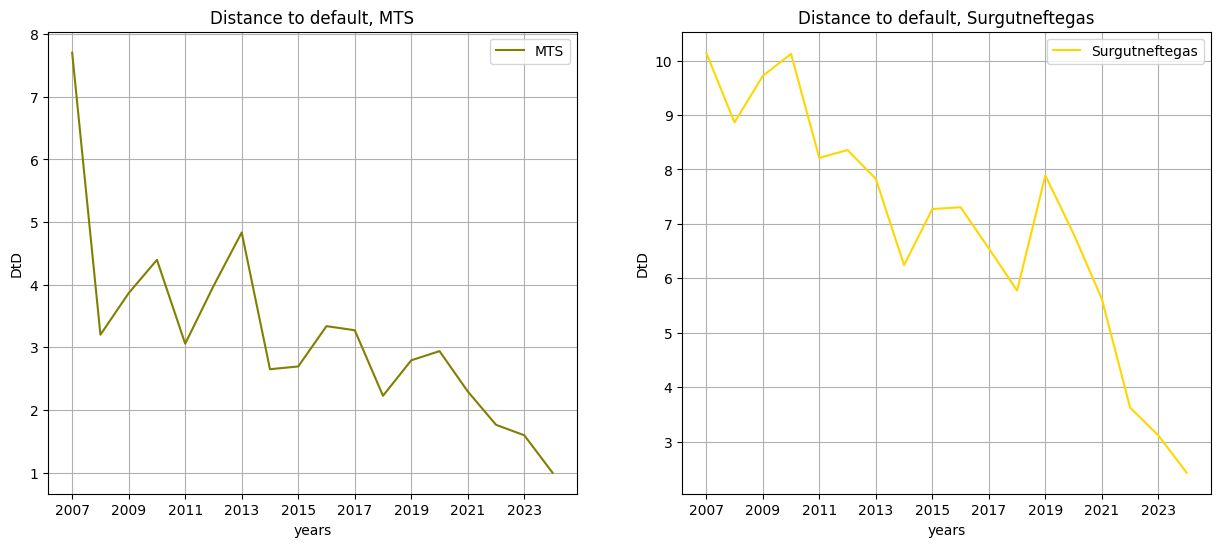

In [100]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(data_mts['date'], dd_1, color="olive", label=f'MTS')
ax2.plot(data_surgut['date'], dd_2, color="gold", label=f'Surgutneftegas')

ax1.set_xlabel('years')
ax1.set_ylabel('DtD')
ax1.set_title('Distance to default, MTS')
ax1.set_xticks(range(2007, 2024 + 1, 2))
ax1.legend()
ax1.grid()

ax2.set_xlabel('years')
ax2.set_ylabel('DtD')
ax2.set_title('Distance to default, Surgutneftegas')
ax2.set_xticks(range(2007, 2024 + 1, 2))
ax2.legend()
ax2.grid()
plt.show()

The retrieved data contained values only from 2007-2024 period.

MTS: furthest away from default in 2007 and 2013, closest to default in 2019-2024.

Surgutneftegas: furthest away from default in 2007-2010, closest to default in 2022-2024.

In [101]:
# calculation of default probability from distance-to-default
def dd_to_pd(dd_array):
    """
    Calculate default probability from distance-to-default values using the Merton model.
    
    Parameters:
    dd : distance-to-default values
    
    Returns:
    numpy array of default probabilities
    """
    # In the Merton model default probability = N(-DD)
    return norm.cdf(-dd_array)

# calculation of default probabilities for both companies
pd_1 = dd_to_pd(dd_1[::-1])  # Default probabilities for MTS
pd_2 = dd_to_pd(dd_2[::-1])  # Default probabilities for Surgutneftegas

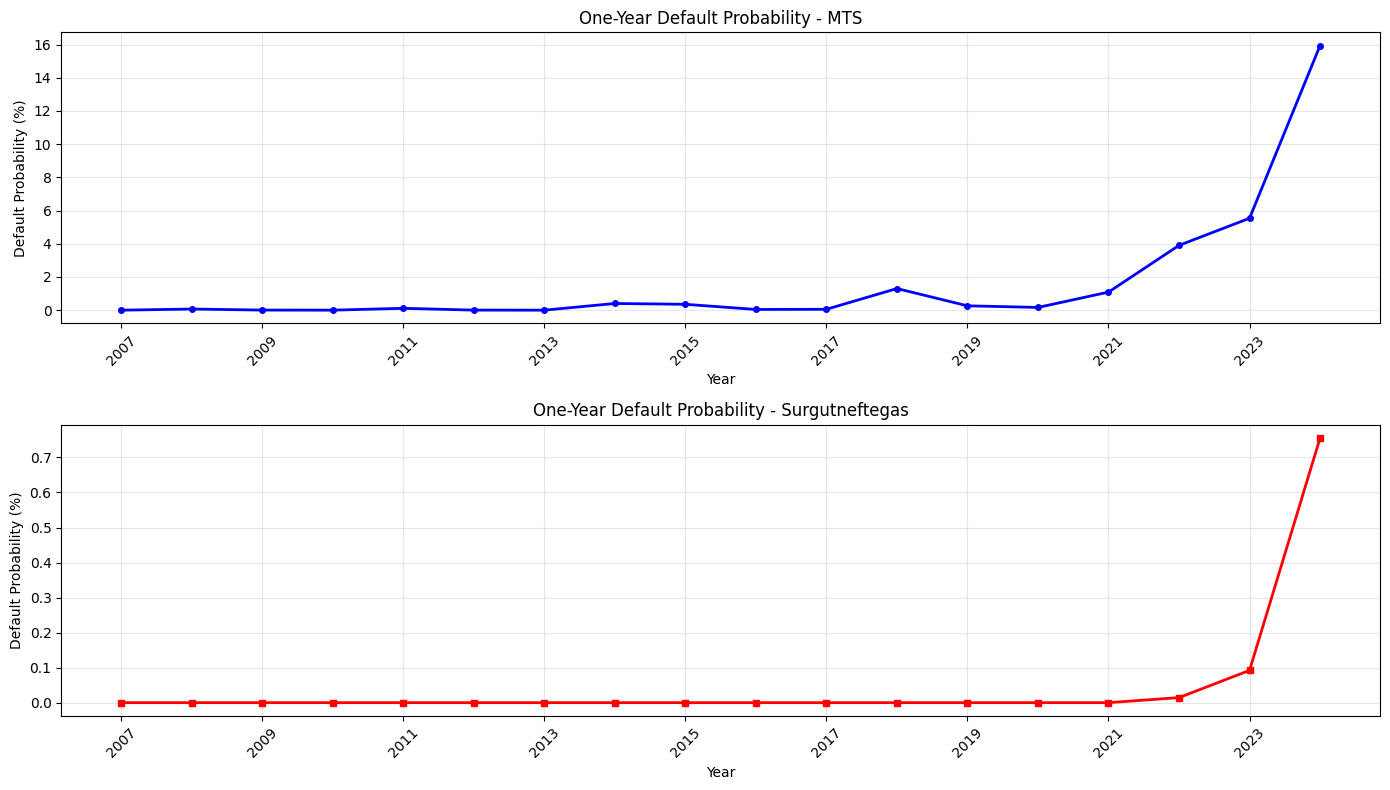

In [102]:
years = np.arange(2007, 2025) 

plt.figure(figsize=(14, 8))

# Plot for MTS
plt.subplot(2, 1, 1)
plt.plot(years, pd_1 * 100, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Year')
plt.ylabel('Default Probability (%)')
plt.title('One-Year Default Probability - MTS')
plt.grid(True, alpha=0.3)
plt.xticks(years[::2], rotation=45)  

# Plot for Surgutneftegas
plt.subplot(2, 1, 2)
plt.plot(years, pd_2 * 100, 'r-', linewidth=2, marker='s', markersize=4)
plt.xlabel('Year')
plt.ylabel('Default Probability (%)')
plt.title('One-Year Default Probability - Surgutneftegas')
plt.grid(True, alpha=0.3)
plt.xticks(years[::2], rotation=45)

plt.tight_layout()
plt.show()

In [104]:
def calculate_summary_stats(pd_array, company_name):
    """Calculate summary statistics for default probabilities."""
    stats = {
        'Company': company_name,
        'Mean (%)': np.mean(pd_array) * 100,
        'Std Dev (%)': np.std(pd_array) * 100,
        'Median (%)': np.median(pd_array) * 100,
        'Min (%)': np.min(pd_array) * 100,
        'Max (%)': np.max(pd_array) * 100,
        '25th Percentile (%)': np.percentile(pd_array, 25) * 100,
        '75th Percentile (%)': np.percentile(pd_array, 75) * 100
    }
    return stats

stats_1 = calculate_summary_stats(pd_1, 'MTS')
stats_2 = calculate_summary_stats(pd_2, 'Surgutneftegas')

# Create DataFrame for display
summary_df = pd.DataFrame([stats_1, stats_2])
summary_df = summary_df.set_index('Company')

# Display formatted summary statistics
print("\nMTS:")
print(f"Mean Default Probability: {stats_1['Mean (%)']:.4f}%")
print(f"Standard Deviation: {stats_1['Std Dev (%)']:.4f}%")
print(f"Median Default Probability: {stats_1['Median (%)']:.4f}%")
print(f"Minimum Default Probability: {stats_1['Min (%)']:.4f}%")
print(f"Maximum Default Probability: {stats_1['Max (%)']:.4f}%")
print(f"25th Percentile: {stats_1['25th Percentile (%)']:.4f}%")
print(f"75th Percentile: {stats_1['75th Percentile (%)']:.4f}%")

print("\nSurgutneftegas:")
print(f"Mean Default Probability: {stats_2['Mean (%)']:.4f}%")
print(f"Standard Deviation: {stats_2['Std Dev (%)']:.4f}%")
print(f"Median Default Probability: {stats_2['Median (%)']:.4f}%")
print(f"Minimum Default Probability: {stats_2['Min (%)']:.4f}%")
print(f"Maximum Default Probability: {stats_2['Max (%)']:.4f}%")
print(f"25th Percentile: {stats_2['25th Percentile (%)']:.4f}%")
print(f"75th Percentile: {stats_2['75th Percentile (%)']:.4f}%")


MTS:
Mean Default Probability: 1.6247%
Standard Deviation: 3.7701%
Median Default Probability: 0.1384%
Minimum Default Probability: 0.0000%
Maximum Default Probability: 15.9425%
25th Percentile: 0.0147%
75th Percentile: 0.9165%

Surgutneftegas:
Mean Default Probability: 0.0479%
Standard Deviation: 0.1729%
Median Default Probability: 0.0000%
Minimum Default Probability: 0.0000%
Maximum Default Probability: 0.7553%
25th Percentile: 0.0000%
75th Percentile: 0.0000%


While MTS showed higher average default probability over the full sample (1.62% vs 0.05%) with more volatility, Surgutneftegas exhibits a significant risk in 2024 with 70% default probability versus MTS's 15%. This reflects severe post-2022 stress in the Russian energy sector versus relative resilience in telecom. The Black-Scholes-Merton model successfully captures this dramatic sector crisis.

The Black-Scholes-Merton model is good for spotting which company is riskier and when risk changes, but it tends to give extreme and unrealistic numbers in real situations—especially for Russian companies after 2022.

For example, it correctly showed that Surgutneftegas became much riskier than MTS by 2024. However, the model estimated a 70% chance of default, which seems too high for a large, important oil company that is still operating. In reality, such companies often receive government support and don’t fail easily.

The model works well because it uses stock market data to measure risk continuously, but it assumes markets behave smoothly and volatility stays the same—which is not true when sanctions hit or markets are unstable.

For Russian firms, it’s better to use the model to compare risks between companies or track risk trends over time, rather than taking the exact probability numbers literally.